In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load and preprocess the dataset
def preprocess(data):
    image = tf.cast(data['image'], tf.float32) / 127.5 - 1
    return image

In [3]:
# Load CIFAR-10 dataset
train_ds = tfds.load('cifar10', split='train')
train_ds = train_ds.map(preprocess).shuffle(10000).batch(64)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.ZIKJ2W_3.0.2/cifar10-train.tfrecord*...:   0%|         …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.ZIKJ2W_3.0.2/cifar10-test.tfrecord*...:   0%|          …

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [4]:
# Define the U-Net model
def unet_conv_block(inputs, filters, kernel_size=3):
    x = tf.keras.layers.Conv2D(filters, kernel_size, activation='relu', padding='same')(inputs)
    x = tf.keras.layers.Conv2D(filters, kernel_size, activation='relu', padding='same')(x)
    return x

In [5]:
def unet_model():
    inputs = tf.keras.layers.Input(shape=(32, 32, 3))

    # Encoder
    conv1 = unet_conv_block(inputs, 64)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = unet_conv_block(pool1, 128)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = unet_conv_block(pool2, 256)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bridge
    conv4 = unet_conv_block(pool3, 512)

    # Decoder
    up5 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv4)
    up5 = tf.keras.layers.concatenate([up5, conv3])
    conv5 = unet_conv_block(up5, 256)

    up6 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv5)
    up6 = tf.keras.layers.concatenate([up6, conv2])
    conv6 = unet_conv_block(up6, 128)

    up7 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv6)
    up7 = tf.keras.layers.concatenate([up7, conv1])
    conv7 = unet_conv_block(up7, 64)

    outputs = tf.keras.layers.Conv2D(3, 1, activation=None, padding='same')(conv7)

    return tf.keras.Model(inputs=inputs, outputs=outputs, name = 'U-Net')

model = unet_model()

In [6]:
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 32, 32, 64)           36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 16, 16, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [7]:
# Define the diffusion process
num_timesteps = 1000
betas = tf.linspace(1e-4, 0.02, num_timesteps)
alphas = 1.0 - betas
alphas_cumprod = tf.math.cumprod(alphas)

In [8]:
@tf.function
def forward_diffusion(x, t):
    noise = tf.random.normal(shape=x.shape)
    mean = tf.sqrt(tf.gather(alphas_cumprod, t))[:, tf.newaxis, tf.newaxis, tf.newaxis] * x
    var = 1.0 - tf.gather(alphas_cumprod, t)
    return mean + tf.sqrt(var)[:, tf.newaxis, tf.newaxis, tf.newaxis] * noise, noise

In [9]:
# Training loop
@tf.function
def train_step(images):
    t = tf.random.uniform(shape=[tf.shape(images)[0]], minval=0, maxval=num_timesteps, dtype=tf.int32)
    noisy_images, noise = forward_diffusion(images, t)

    with tf.GradientTape() as tape:
        predicted_noise = model(noisy_images, training=True)
        loss = tf.reduce_mean(tf.square(noise - predicted_noise))

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [10]:
# Modified sampling function to start from partially noised sample
def sample_from_partial_noise(image, start_t):
    x = image
    for t in tf.range(start_t - 1, -1, -1):
        z = tf.random.normal(shape=tf.shape(x)) if t > 0 else tf.zeros_like(x)
        predicted_noise = model(x, training=False)
        alpha = tf.gather(alphas, t)
        alpha_cumprod = tf.gather(alphas_cumprod, t)
        x = 1 / tf.sqrt(alpha) * (x - (1 - alpha) / tf.sqrt(1 - alpha_cumprod) * predicted_noise)
        x = x + tf.sqrt(tf.gather(betas, t)) * z
    return x

In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
epochs = 60

for epoch in range(epochs):
    for images in train_ds:
        loss = train_step(images)

    print(f"Epoch {epoch + 1}, Loss: {loss.numpy():.4f}")

print("Training completed!")

Epoch 1, Loss: 0.0802
Epoch 2, Loss: 0.0564
Epoch 3, Loss: 0.0764
Epoch 4, Loss: 0.0699
Epoch 5, Loss: 0.1105
Epoch 6, Loss: 0.0619
Epoch 7, Loss: 0.0520
Epoch 8, Loss: 0.0260
Epoch 9, Loss: 0.0433
Epoch 10, Loss: 0.0360
Epoch 11, Loss: 0.0134
Epoch 12, Loss: 0.1394
Epoch 13, Loss: 0.0345
Epoch 14, Loss: 0.0258
Epoch 15, Loss: 0.0487
Epoch 16, Loss: 0.0612
Epoch 17, Loss: 0.0579
Epoch 18, Loss: 0.0312
Epoch 19, Loss: 0.0845
Epoch 20, Loss: 0.0391
Epoch 21, Loss: 0.0610
Epoch 22, Loss: 0.0429
Epoch 23, Loss: 0.0497
Epoch 24, Loss: 0.0298
Epoch 25, Loss: 0.0297
Epoch 26, Loss: 0.0177
Epoch 27, Loss: 0.0297
Epoch 28, Loss: 0.0338
Epoch 29, Loss: 0.0510
Epoch 30, Loss: 0.0469
Epoch 31, Loss: 0.0386
Epoch 32, Loss: 0.0268
Epoch 33, Loss: 0.0261
Epoch 34, Loss: 0.0717
Epoch 35, Loss: 0.0097
Epoch 36, Loss: 0.0638
Epoch 37, Loss: 0.0472
Epoch 38, Loss: 0.0268
Epoch 39, Loss: 0.0666
Epoch 40, Loss: 0.0166
Epoch 41, Loss: 0.0390
Epoch 42, Loss: 0.0399
Epoch 43, Loss: 0.0223
Epoch 44, Loss: 0.07

In [16]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from tensorflow.keras.applications.inception_v3 import InceptionV3
import numpy as np

# Load pre-trained InceptionV3 for feature extraction
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

def preprocess_image_for_inception(image):
    image = tf.image.resize(image, (299, 299))
    image = tf.clip_by_value(image, -1, 1)  # Ensure the range is [-1, 1]
    return image

def calculate_inception_distance(real_image, generated_image):
    real_image = preprocess_image_for_inception(real_image)
    generated_image = preprocess_image_for_inception(generated_image)

    real_features = inception_model.predict(real_image[tf.newaxis, ...])
    generated_features = inception_model.predict(generated_image[tf.newaxis, ...])

    # Calculate Euclidean distance between feature vectors
    distance = np.linalg.norm(real_features - generated_features)
    return distance

def calculate_metrics(original, denoised):
    original = (original.numpy()[0] + 1) / 2  # Convert to [0, 1] range
    denoised = (denoised.numpy()[0] + 1) / 2  # Convert to [0, 1] range

    ssim_value = ssim(original, denoised, multichannel=True)
    psnr_value = psnr(original, denoised)
    inception_distance = calculate_inception_distance(original, denoised)

    return ssim_value, psnr_value, inception_distance


<ipython-input-16-3e9bfe236704>:29: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(original, denoised, multichannel=True)


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 24ms/step


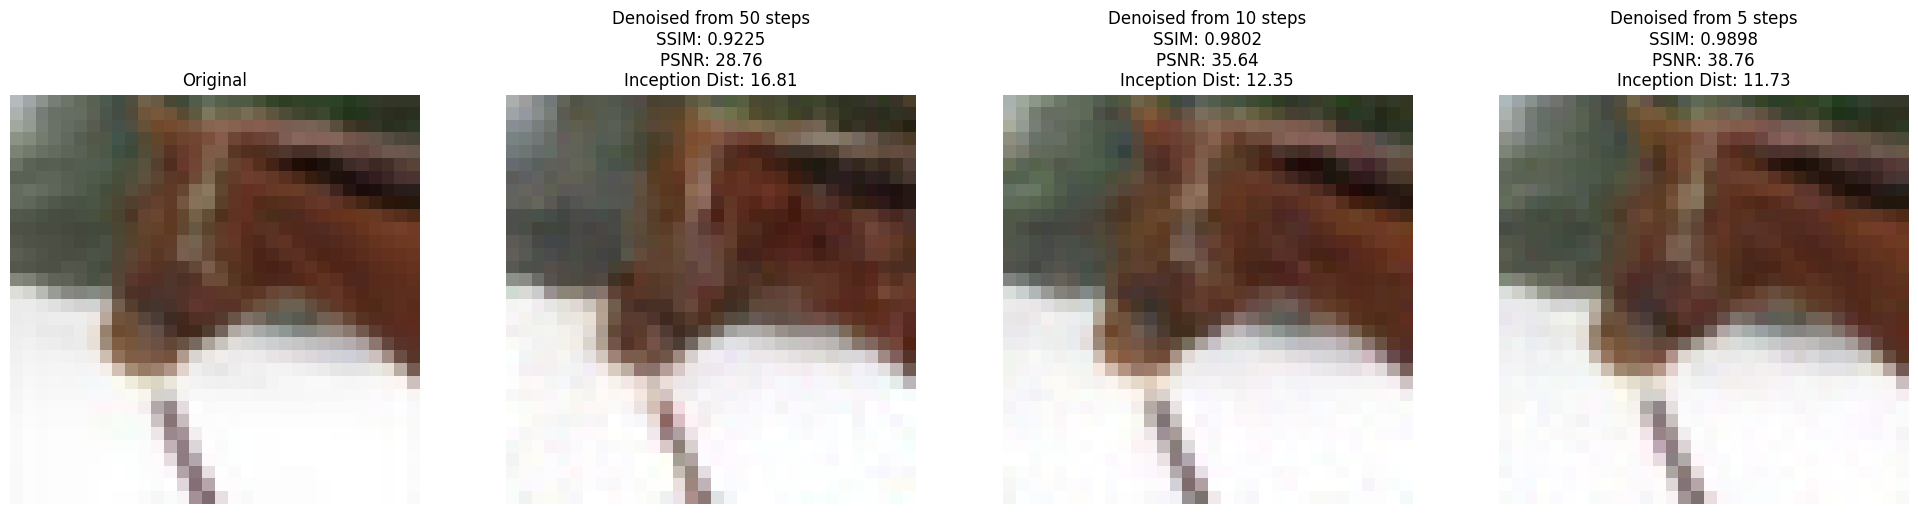

In [17]:
# Test denoising from partial noise
test_ds = tfds.load('cifar10', split='test')
test_ds = test_ds.map(preprocess).batch(1)

for test_image in test_ds.take(1):
    original_image = test_image

    noise_levels = [50, 10, 5]
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    axes[0].imshow((original_image[0].numpy() + 1) / 2)
    axes[0].set_title("Original")
    axes[0].axis('off')

    for i, noise_level in enumerate(noise_levels):
        # Add noise
        noisy_image, _ = forward_diffusion(original_image, tf.constant([noise_level]))

        # Denoise
        denoised_image = sample_from_partial_noise(noisy_image, noise_level)

        # Calculate metrics
        ssim_value, psnr_value, inception_distance = calculate_metrics(original_image, denoised_image)

        # Display
        axes[i+1].imshow((denoised_image[0].numpy() + 1) / 2)
        axes[i+1].set_title(f"Denoised from {noise_level} steps\nSSIM: {ssim_value:.4f}\nPSNR: {psnr_value:.2f}\nInception Dist: {inception_distance:.2f}")
        axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()
    break  # We only need one sample for demonstration

The model is able to denoise the noisy sample to a great extent. 

1. The denoised image is visually similar to the original image, with most of the noise removed. 
2. However, the model has added some very minute new features to the image while denoising it. 
3. Model fails to construct the eye pixel for above image when denoised from steps 10 and 50. 

* Inception score is decreasing when we reduce the time steps to denoise, which is as expected, infact ssim, psnr values are also as expected
* Higher the ssim, better the generations
* psnr score above 30, is good enough
* inception score is inshort the distance between the real and re-constructed image, shorter the dostance better is the model's performance